In [87]:
import os
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [88]:
#######################################################################################################
#Load saved model
#######################################################################################################
os.chdir(r'I:\SLIOT-backend\modelsave')
ts_model=load_model(os.path.join(os.getcwd(), "lstm_model.h5"))
ts_model.summary()
#######################################################################################################
np.random.seed(1)
#Load the sequence data from csv
df = pd.read_csv('I:\SLIOT-backend\originaldataset\AEP_hourly.csv')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               434688    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 434,817
Trainable params: 434,817
Non-trainable params: 0
_________________________________________________________________


Quick look at data

In [89]:
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [90]:
# Concise summary of a DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [91]:
requests = pd.DataFrame(data=df,columns=['AEP_MW'])
#if any missing value fill it by previous value and convert all requests into integer type
requests.ffill(inplace=True)
requests["AEP_MW"]=requests["AEP_MW"].astype(float).astype(int)

In [92]:

##############################################################################################################
dataset = df
dataset["Month"] = pd.to_datetime(df["Datetime"]).dt.month
dataset["Year"] = pd.to_datetime(df["Datetime"]).dt.year
dataset["Date"] = pd.to_datetime(df["Datetime"]).dt.date
dataset["Time"] = pd.to_datetime(df["Datetime"]).dt.time
dataset["Week"] = pd.to_datetime(df["Datetime"]).dt.isocalendar().week
dataset["Day"] = pd.to_datetime(df["Datetime"]).dt.day_name()
dataset = df.set_index("Datetime")
dataset.index = pd.to_datetime(dataset.index)


Data Time Period

In [93]:

dataset['Date'].min(), dataset['Date'].max()

(datetime.date(2004, 10, 1), datetime.date(2018, 8, 3))

In [116]:
!pip install nbformat latest

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for latest: filename=latest-0.6.0-py3-none-any.whl size=7818 sha256=d150d3cdef60109dc3a6c3a01b3545cd6afad16046b5634982633b45e3d6013b
  Stored in directory: c:\users\administrator\appdata\local\pip\cache\wheels\ac\09\2f\490b94c68079085967c33e263139607e5500e3bb9b9c512b6f
Successfully built latest



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [117]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['AEP_MW'], name='AEP_MW'))
fig.update_layout(showlegend=True, title='Electricity usage 2004-2020')
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Data Preprocessing

1. Train - test split

In [94]:
startdate = pd.to_datetime("2004-11-7").date()
enddate = pd.to_datetime("2018-6-10").date()
train = df.loc[df['Date'] <= startdate]
test = df.loc[df['Date'] > enddate]
train.shape, test.shape

((910, 8), (1273, 8))

Data Scaling

In [95]:
scaler = StandardScaler()
scaler = scaler.fit(np.array(train['AEP_MW']).reshape(-1,1))

train['AEP_MW'] = scaler.transform(np.array(train['AEP_MW']).reshape(-1,1))
test['AEP_MW'] = scaler.transform(np.array(test['AEP_MW']).reshape(-1,1))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3936\282904655.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3936\282904655.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



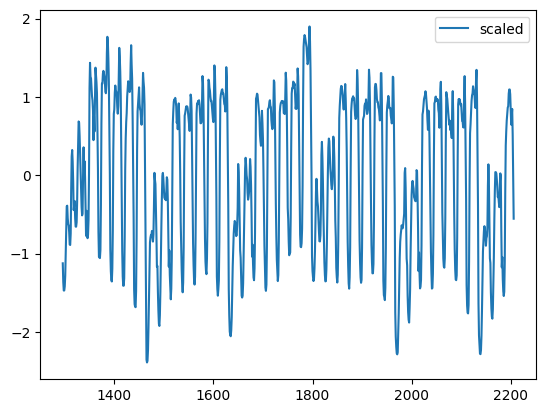

In [96]:
# Visualize scaled data
plt.plot(train['AEP_MW'], label = 'scaled')
plt.legend()
plt.show()

Create sequences

In [97]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])
    
    return np.array(X_out), np.array(y_out)

X_train, y_train = create_sequences(train[['AEP_MW']], train['AEP_MW'])
X_test, y_test = create_sequences(test[['AEP_MW']], test['AEP_MW'])
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (880, 30, 1)
Testing input shape:  (1243, 30, 1)


Build a model

In [105]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, activation = 'tanh', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_4 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_11 (LSTM)              (None, 30, 128)           131584    
                                                                 
 dropout_11 (Dropout)        (None, 30, 128)           0         
                                                                 
 time_distributed_5 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

In [106]:
history = model.fit(X_train,
                    y_train,
                    epochs=300,
                    batch_size=1500,
                    validation_split=0.1)

Epoch 1/300
1/1 [==============================] - 6s 6s/step - loss: 0.9982 - val_loss: 1.2046
Epoch 2/300
1/1 [==============================] - 1s 674ms/step - loss: 1.0027 - val_loss: 1.1953
Epoch 3/300
1/1 [==============================] - 1s 672ms/step - loss: 0.9953 - val_loss: 1.1905
Epoch 4/300
1/1 [==============================] - 1s 702ms/step - loss: 0.9954 - val_loss: 1.1923
Epoch 5/300
1/1 [==============================] - 1s 734ms/step - loss: 0.9976 - val_loss: 1.1950
Epoch 6/300
1/1 [==============================] - 1s 710ms/step - loss: 0.9966 - val_loss: 1.1981
Epoch 7/300
1/1 [==============================] - 1s 641ms/step - loss: 0.9950 - val_loss: 1.2014
Epoch 8/300
1/1 [==============================] - 1s 652ms/step - loss: 0.9942 - val_loss: 1.2037
Epoch 9/300
1/1 [==============================] - 1s 662ms/step - loss: 0.9945 - val_loss: 1.2036
Epoch 10/300
1/1 [==============================] - 1s 657ms/step - loss: 0.9948 - val_loss: 1.2011
Epoch 11/300

Plot Training - Validation loss

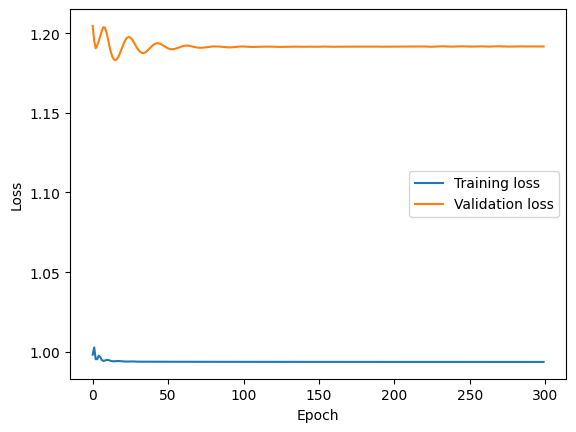

In [107]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

28/28 [==============================] - 2s 15ms/step
Reconstruction error threshold: 1.2933192305690722


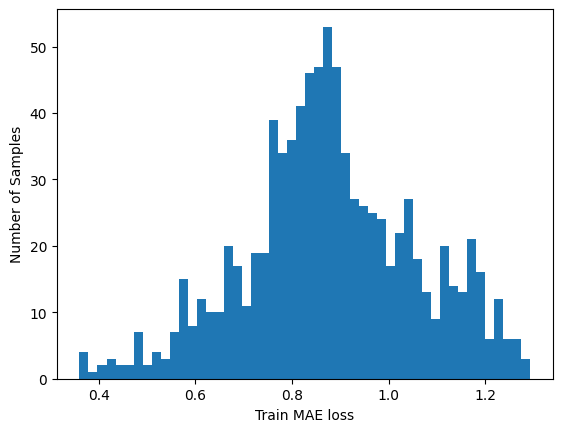

In [108]:
# Mean Absolute Error loss
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)

print('Reconstruction error threshold:',threshold)

Predict Anomalies on test data using threshold

39/39 [==============================] - 1s 14ms/step


Text(0, 0.5, 'Number of samples')

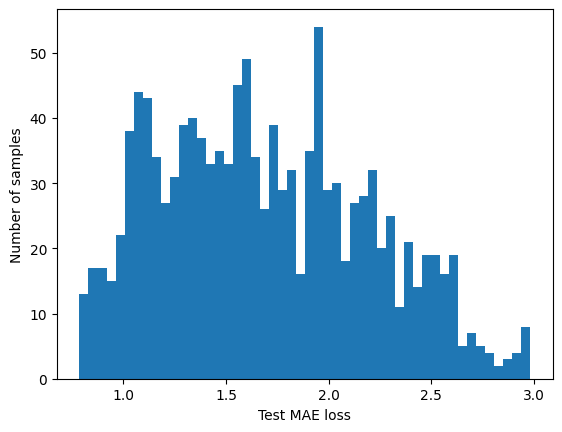

In [109]:
X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [110]:
anomaly_df = pd.DataFrame(test[TIME_STEPS:])
anomaly_df['loss'] = test_mae_loss
anomaly_df['threshold'] = threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']

In [111]:

anomaly_df.head()

,Datetime,AEP_MW,Month,Year,Date,Time,Week,Day,loss,threshold,anomaly
116168,2018-08-01 07:00:00,-0.323026,8,2018,2018-08-01,07:00:00,31,Wednesday,1.418200,1.293319,True
116169,2018-08-01 08:00:00,0.076232,8,2018,2018-08-01,08:00:00,31,Wednesday,1.413372,1.293319,True
116170,2018-08-01 09:00:00,0.423910,8,2018,2018-08-01,09:00:00,31,Wednesday,1.381678,1.293319,True
116171,2018-08-01 10:00:00,0.766495,8,2018,2018-08-01,10:00:00,31,Wednesday,1.355344,1.293319,True
116172,2018-08-01 11:00:00,1.037124,8,2018,2018-08-01,11:00:00,31,Wednesday,1.335346,1.293319,True


In [113]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [74]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies.head()

,Datetime,AEP_MW,Month,Year,Date,Time,Week,Day,loss,threshold,anomaly
116168,2018-08-01 07:00:00,-0.323026,8,2018,2018-08-01,07:00:00,31,Wednesday,1.416628,1.308433,True
116169,2018-08-01 08:00:00,0.076232,8,2018,2018-08-01,08:00:00,31,Wednesday,1.411686,1.308433,True
116170,2018-08-01 09:00:00,0.423910,8,2018,2018-08-01,09:00:00,31,Wednesday,1.380783,1.308433,True
116171,2018-08-01 10:00:00,0.766495,8,2018,2018-08-01,10:00:00,31,Wednesday,1.355667,1.308433,True
116172,2018-08-01 11:00:00,1.037124,8,2018,2018-08-01,11:00:00,31,Wednesday,1.337334,1.308433,True


In [75]:
anomalies.shape

(908, 11)

In [84]:
!pip install nbformat 

SyntaxError: invalid syntax (1904701138.py, line 2)

In [83]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['AEP_MW'], name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=anomalies['AEP_MW'], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed